Diagnoses use ICD9 - can cluster them into the chapters: https://en.wikipedia.org/wiki/List_of_ICD-9_codes

We already have:
- number of medications
- We have discharge dest and if they were admitted as an emergency


Initial thoughts:

- From the data, those with more medical history - more hospital visits, etc., more medications, 
- discharged to home also was less on non-readdmissions - but discharged to home /w some health service etc. was higher - aligns with people with more medical needs not doing welll after they leave hospital
- also those with "change" in medication see higher rates of readmission
- those with diabetes meds see higher rates of readmission

The story is, those with complex health needs, (made easier to get meds wrong if they've changed), are more likely to see readmission

NEED TO LOOK AT CHARLSON

In [1]:
import pandas as pd

# Specify the file path
file_path = "data/Diabetes.xlsx"

# Load the Excel file into a pandas dataframe
df = pd.read_excel(file_path)

# Display the dataframe
df

d:\PycharmProjects\readmission\.venv\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,readmitted,diag_1_desc,diag_2_desc,diag_3_desc
0,Caucasian,Female,[50-60),?,Elective,Discharged to home,Physician Referral,1,CP,Surgery-Neuro,...,No,No,No,No,No,No,False,Spinal stenosis in cervical region,Spinal stenosis in cervical region,"Effusion of joint, site unspecified"
1,Caucasian,Female,[20-30),[50-75),Urgent,Discharged to home,Physician Referral,2,UN,?,...,No,No,No,No,No,No,False,"First-degree perineal laceration, unspecified ...","Diabetes mellitus of mother, complicating preg...",Sideroblastic anemia
2,Caucasian,Male,[80-90),?,Not Available,Discharged/transferred to home with home healt...,NaN,7,MC,Family/GeneralPractice,...,No,No,No,No,No,Yes,True,Pneumococcal pneumonia [Streptococcus pneumoni...,"Congestive heart failure, unspecified",Hyperosmolality and/or hypernatremia
3,AfricanAmerican,Female,[50-60),?,Emergency,Discharged to home,Transfer from another health care facility,4,UN,?,...,No,No,No,No,No,Yes,False,Cellulitis and abscess of face,Streptococcus infection in conditions classifi...,Diabetes mellitus without mention of complicat...
4,AfricanAmerican,Female,[50-60),?,Emergency,Discharged to home,Emergency Room,5,?,Psychiatry,...,No,No,No,No,Ch,Yes,False,"Bipolar I disorder, single manic episode, unsp...",Diabetes mellitus without mention of complicat...,Depressive type psychosis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Caucasian,Female,[60-70),?,Elective,Discharged/transferred to home with home healt...,Physician Referral,3,MC,?,...,No,No,No,No,Ch,Yes,False,"Osteoarthrosis, generalized, site unspecified",Malignant essential hypertension,Pure hypercholesterolemia
9996,AfricanAmerican,Male,[60-70),?,Urgent,Discharged/transferred to SNF,Emergency Room,8,CM,Emergency/Trauma,...,No,No,No,No,Ch,Yes,False,"Acute, but ill-defined, cerebrovascular disease",Diabetes mellitus without mention of complicat...,Fitting and adjustment of other device
9997,AfricanAmerican,Female,[70-80),?,Emergency,Discharged/transferred to home with home healt...,Emergency Room,13,?,InternalMedicine,...,No,No,No,No,No,No,True,Streptococcal septicemia,Chronic kidney disease (ckd),Achlorhydria
9998,Caucasian,Male,[80-90),?,Urgent,Discharged/transferred to SNF,Emergency Room,2,MC,InternalMedicine,...,No,No,No,No,No,No,False,"Acute gastritis, without mention of hemorrhage",Hyperosmolality and/or hypernatremia,"Urinary tract infection, site not specified"


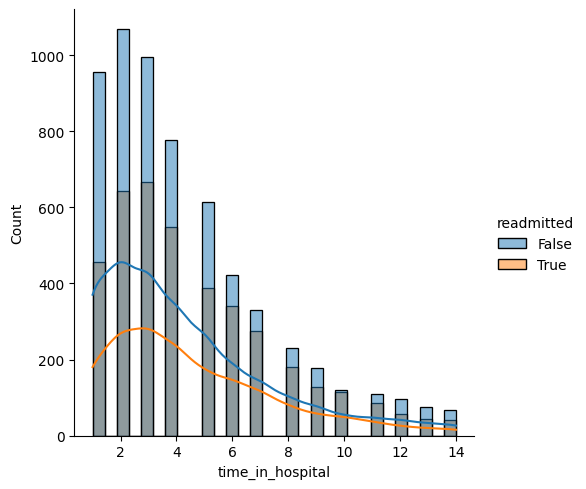

In [2]:
import seaborn as sns

# make histogram of age variable split by readmitted
sns.displot(df, x='time_in_hospital', bins=30, kde=True,hue='readmitted')

           time_in_hospital                                              
                      count      mean       std  min  25%  50%  75%   max
readmitted                                                               
False                6035.0  4.308534  3.027208  1.0  2.0  4.0  6.0  14.0
True                 3965.0  4.626734  3.003260  1.0  2.0  4.0  6.0  14.0
           num_lab_procedures                                               \
                        count       mean        std  min   25%   50%   75%   
readmitted                                                                   
False                  6035.0  41.791218  19.244476  1.0  30.0  43.0  55.0   
True                   3965.0  45.038083  19.607779  1.0  34.0  46.0  60.0   

                   
              max  
readmitted         
False       120.0  
True        108.0  
           num_procedures                                             
                    count      mean       std  min  25%  50%  75%  m

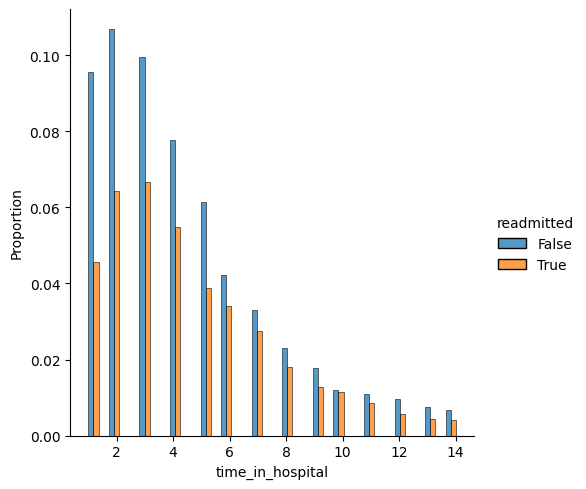

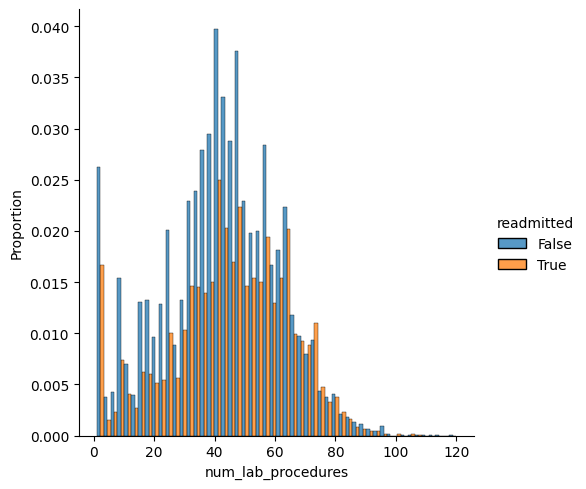

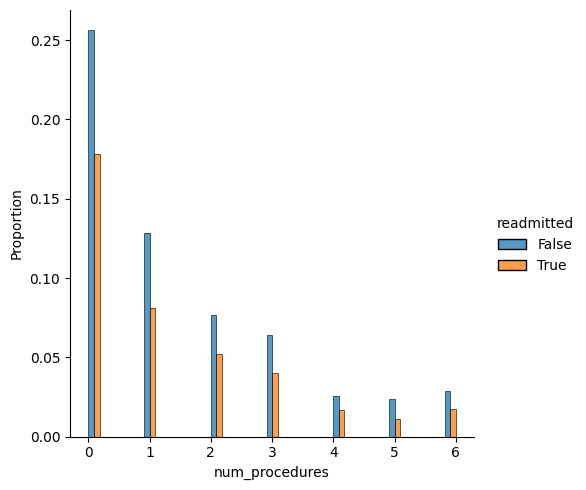

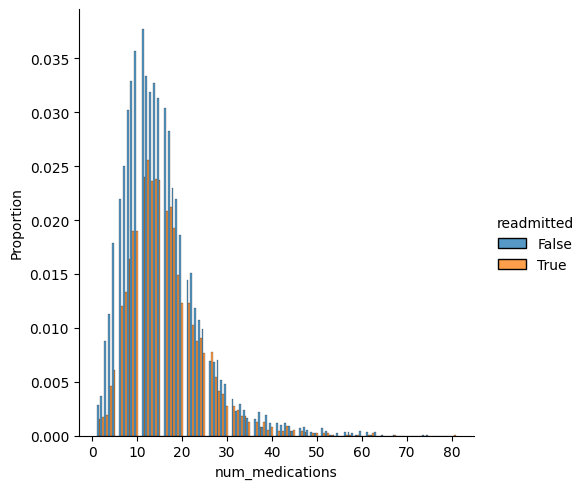

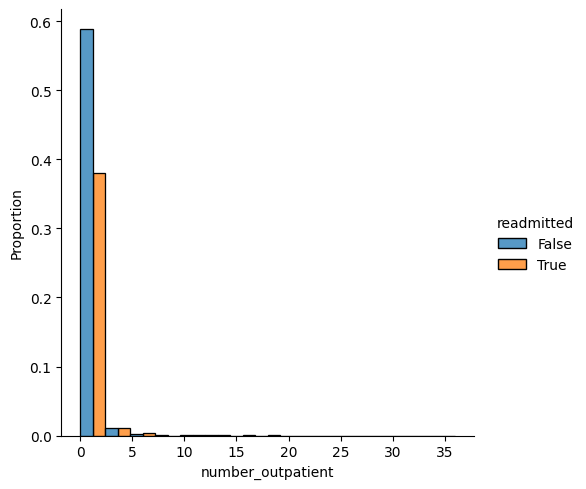

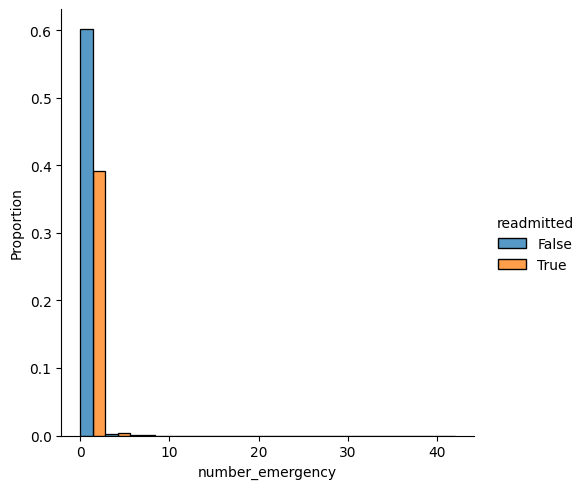

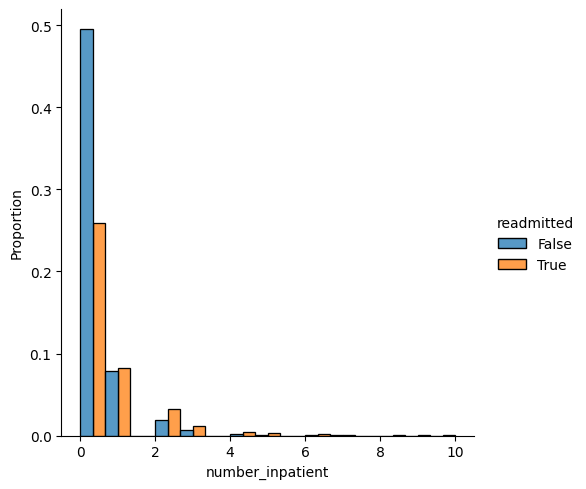

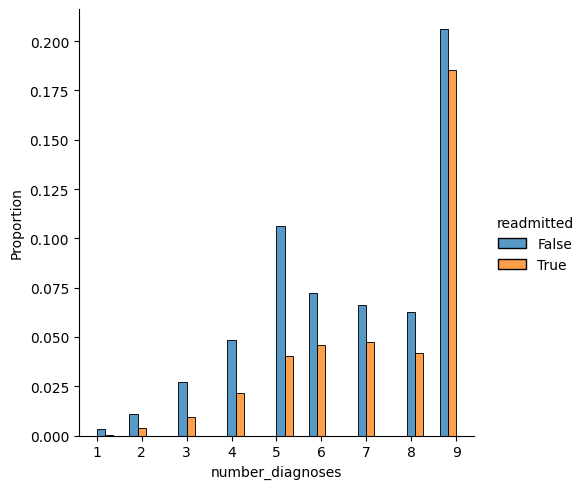

In [3]:
for int64_column in df.columns[df.dtypes == 'int64']:
    #print(int64_column)
    sns.displot(df, x=int64_column,hue='readmitted', stat='proportion', multiple='dodge')
    group_readmitted = df.loc[:,[int64_column,'readmitted']].groupby('readmitted')
    print(group_readmitted.describe())


In [4]:
def group_and_value_count_by_readmitted(df,column):
    """Returns a dataframe with the count of each value in the specified column grouped by readmitted"""
    
    group_readmitted = df.loc[:,[column,'readmitted']].groupby('readmitted')

    return pd.concat([group_readmitted.value_counts(normalize=True),
               group_readmitted.value_counts()
               ],axis=1)

for cat_column in df.columns[df.dtypes == 'object']:
    print(group_and_value_count_by_readmitted(df,cat_column))

    

                            proportion  count
readmitted race                              
False      Caucasian          0.711682   4295
           AfricanAmerican    0.222204   1341
           ?                  0.027672    167
           Hispanic           0.019221    116
           Other              0.013256     80
           Asian              0.005965     36
True       Caucasian          0.772762   3064
           AfricanAmerican    0.182093    722
           Hispanic           0.016393     65
           ?                  0.013619     54
           Other              0.010340     41
           Asian              0.004792     19
                   proportion  count
readmitted gender                   
False      Female    0.534714   3227
           Male      0.465286   2808
True       Female    0.547541   2171
           Male      0.452459   1794
                     proportion  count
readmitted age                        
False      [70-80)     0.244905   1478
           [60-70

In [7]:
medspec = group_and_value_count_by_readmitted(df,"medical_specialty")

# thoughts
- So - this ISNT an imbalanced dataset - so don't need to worry about that

In [59]:
import sklearn

# use a tree model to predict readmission
from sklearn.tree import DecisionTreeClassifier

# import random forest classifier
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

from sklearn.model_selection import train_test_split


# one-hot encode the categorical variables
df_onehot = pd.get_dummies(df.drop('readmitted',axis=1), drop_first=True)

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_onehot, 
                                                    df['readmitted'], test_size=0.30, 
                                                    random_state=101, stratify=df['readmitted'])

# create a decision tree classifier instance
model = GradientBoostingClassifier(n_estimators=100, max_depth=4)

# fit the decision tree classifier
model.fit(X_train,y_train)



train_predictions = model.predict(X_train)

# use the classifier to predict
predictions = model.predict(X_test)

# import the metrics class
from sklearn import metrics

# show the confusion matrix
print(metrics.confusion_matrix(y_test,predictions))

print(metrics.classification_report(y_train,train_predictions))

# show the accuracy, precision, and recall
print(metrics.classification_report(y_test,predictions))

[[1564  246]
 [ 775  415]]
              precision    recall  f1-score   support

       False       0.71      0.91      0.80      4225
        True       0.76      0.42      0.54      2775

    accuracy                           0.72      7000
   macro avg       0.73      0.67      0.67      7000
weighted avg       0.73      0.72      0.69      7000

              precision    recall  f1-score   support

       False       0.67      0.86      0.75      1810
        True       0.63      0.35      0.45      1190

    accuracy                           0.66      3000
   macro avg       0.65      0.61      0.60      3000
weighted avg       0.65      0.66      0.63      3000

